In [1]:
import numpy as np, xarray as xr, matplotlib.pyplot as plt, pandas as pd, s3fs
from utils import *

s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", 
                       client_kwargs=dict(endpoint_url="https://rgw.met.no"))

In [2]:
tos = get_monthly_bucket_data('tos', thing='Omon', model='NorESM2-LM', experiment='historical')

s3://escience2022/Ada/monthly/tos_Omon_NorESM2-LM_historical_*.nc


In [3]:
areacello = get_areacello('NorESM2-LM').squeeze()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [5]:
tosBS = clip_to_region(tos)
areaBS = clip_to_region(areacello)

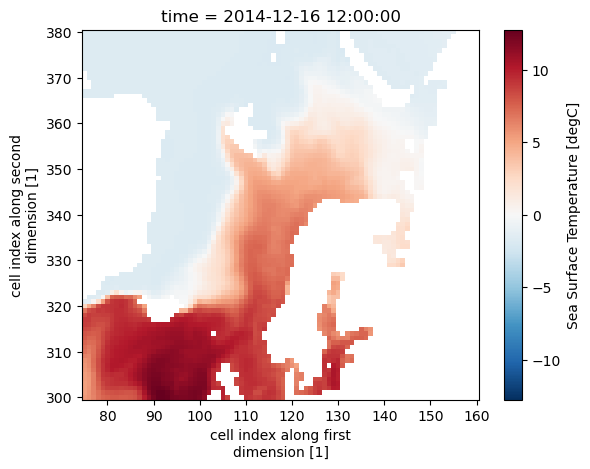

In [6]:
tosBS.tos.isel(time=-1).plot()

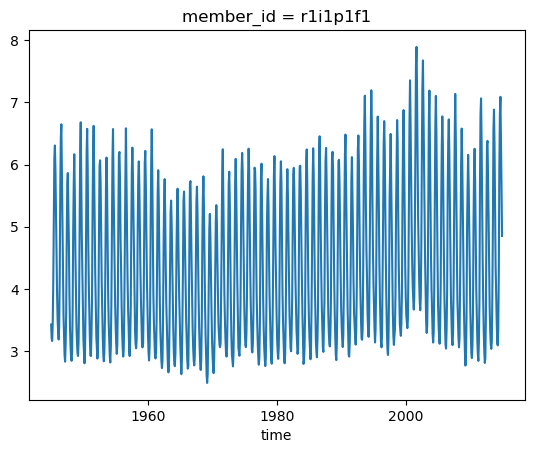

In [22]:
tosBSmean = regional_average(tosBS.tos.isel(time=slice(-12*70, -1)), areaBS.areacello)
tosBSmean.plot(x='time')

In [23]:
SI = get_monthly_bucket_data('siconc', thing='SImon', model='NorESM2-LM', experiment='historical')

s3://escience2022/Ada/monthly/siconc_SImon_NorESM2-LM_historical_*.nc


In [61]:
SIBS = clip_to_region(SI)
SIBSmean = regional_average(SIBS.siconc, areacello.areacello)

SIBSMarch = SIBS.siconc.groupby('time.month')[3]
SIBSMarchSpatialMean = regional_average(SIBSMarch, areacello.areacello)
SIBSMarchTimeMean = SIBSMarch.mean(dim='time')

SIBSSeptember = SIBS.siconc.groupby('time.month')[9]
SIBSSeptemberSpatialMean = regional_average(SIBSSeptember, areacello.areacello)
SIBSSeptemberTimeMean = SIBSSeptember.mean(dim='time')

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12,4))
SIBSMarchSpatialMean.plot(ax=ax[0,0])
SIBSSeptemberSpatialMean.plot(ax=ax[0,1])
SIBSMarchTimeMean.plot(ax=ax[1,0])
SIBSSeptemberTimeMean.plot(ax=ax[1,1])
plt.show()

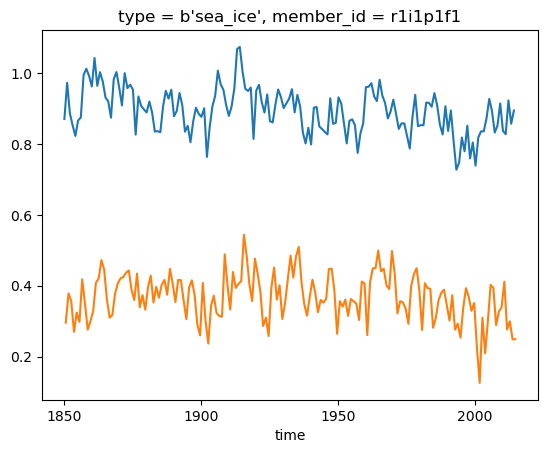

In [46]:
SIBSmeanMarch = SIBSmean.groupby('time.month')[3]
SIBSmeanSeptember = SIBSmean.groupby('time.month')[9]
SIBSmeanMarch.plot()
SIBSmeanSeptember.plot()

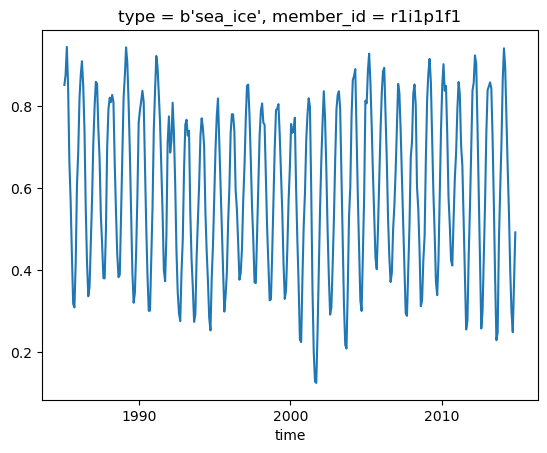

In [35]:
SIBSmean.isel(time=slice(-12*30, -1)).plot(x='time')